In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mltable
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
#from imblearn.over_sampling import SMOTE
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.pipeline import Pipeline as ImbPipeline
#from azureml.train.automl import AutoMLConfig
import joblib
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [2]:
ml_client = MLClient.from_config(credential=DefaultAzureCredential())
data_asset = ml_client.data.get("tele_customer_data", version="1")

tbl = mltable.load(f'azureml:/{data_asset.id}')

df = tbl.to_pandas_dataframe()
df.head()

Found the config file in: /config.json


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,No phone service,DSL,No,...,No,No,No,No,Month-to-month,True,Electronic check,29.85,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,No,DSL,Yes,...,Yes,No,No,No,One year,False,Mailed check,56.95,1889.50,False
2,3668-QPYBK,Male,0,False,False,2,True,No,DSL,Yes,...,No,No,No,No,Month-to-month,True,Mailed check,53.85,108.15,True
3,7795-CFOCW,Male,0,False,False,45,False,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,False,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,No,Fiber optic,No,...,No,No,No,No,Month-to-month,True,Electronic check,70.70,151.65,True


In [3]:
df.shape

(7043, 21)

In [4]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   bool   
 4   Dependents        7043 non-null   bool   
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   bool   
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   bool   


In [6]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [7]:
df['TotalCharges'].fillna(df['TotalCharges'].mean(), inplace=True)


In [8]:
import pip
pip.main(['install','seaborn'])

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/_distutils_hack/__init__.py:31: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: seaborn in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (0.13.2)

Requirement already satisfied: numpy!=1.24.0,>=1.20 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from seaborn) (1.23.5)

Requirement already satisfied: pandas>=1.2 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from seaborn) (1.3.5)

Requirement already satisfied: matplotlib!=3.6.1,>=3.4 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from seaborn) (3.9.2)

Requirement already satisfied: contourpy>=1.0.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.3.0)

Requirement already satisfied: cycler>=0.10 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (0.12.1)

Requirement already satisfied: fonttools>=4.22.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (4.53.1)

Requirement already satisfied: kiwisolver>=1.3.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (1.4.7)

Requirement already satisfied: packaging>=20.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (24.1)

Requirement already satisfied: pillow>=8 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (10.4.0)

Requirement already satisfied: pyparsing>=2.3.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (3.1.4)

Requirement already satisfied: python-dateutil>=2.7 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from matplotlib!=3.6.1,>=3.4->seaborn) (2.9.0)

Requirement already satisfied: pytz>=2017.3 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from pandas>=1.2->seaborn) (2024.2)

Requirement already satisfied: six>=1.5 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from python-dateutil>=2.7->matplotlib!=3.6.1,>=3.4->seaborn) (1.16.0)

0

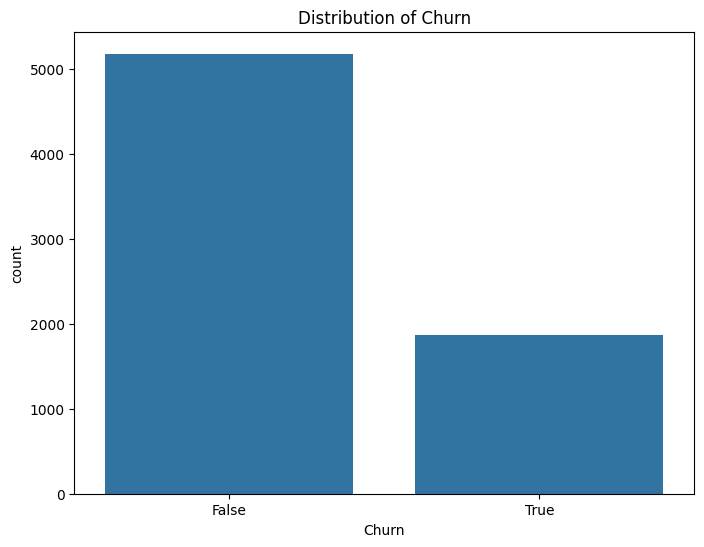

In [9]:

import seaborn as sns
plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn')
plt.show()

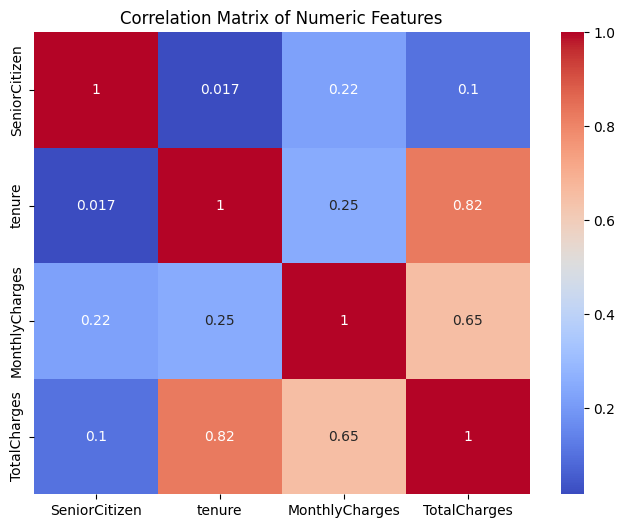

In [10]:
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df[numeric_columns].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [11]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

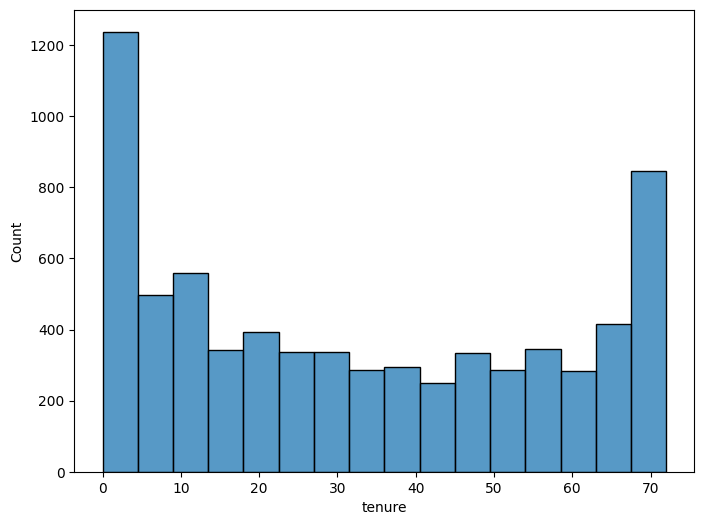

In [12]:
plt.figure(figsize=(8, 6))
sns.histplot(x='tenure', data=df)
plt.show()

In [13]:
X = df
y = df['Churn']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [15]:
cate = df.columns[df.dtypes == 'object']

In [16]:
nums = df.columns[df.dtypes != 'object']

In [17]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, nums),
        ('cat', categorical_transformer, cate)
    ])

In [18]:

pip.main(['install','imblearn'])
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: imblearn in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (0.0)

Requirement already satisfied: imbalanced-learn in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from imblearn) (0.12.4)

Requirement already satisfied: numpy>=1.17.3 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from imbalanced-learn->imblearn) (1.23.5)

Requirement already satisfied: scipy>=1.5.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from imbalanced-learn->imblearn) (1.10.1)

Requirement already satisfied: scikit-learn>=1.0.2 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from imbalanced-learn->imblearn) (1.5.1)

Requirement already satisfied: joblib>=1.1.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from imbalanced-learn->imblearn) (1.2.0)

Requirement already satisfied: threadpoolctl>=2.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from imbalanced-learn->imblearn) (3.5.0)

In [19]:
pip.main(['install','azureml.train.automl'])
from azureml.train.automl import AutoMLConfig

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Requirement already satisfied: azureml.train.automl in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (1.57.0)

Requirement already satisfied: azureml-automl-core~=1.57.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml.train.automl) (1.57.0)

Requirement already satisfied: azureml-automl-runtime~=1.57.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml.train.automl) (1.57.0)

Requirement already satisfied: azureml-dataset-runtime~=1.57.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-dataset-runtime[fuse,pandas]~=1.57.0->azureml.train.automl) (1.57.0)

Requirement already satisfied: azureml-train-automl-client~=1.57.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml.train.automl) (1.57.0)

Requirement already satisfied: azureml-train-automl-runtime~=1.57.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml.train.automl) (1.57.0)

Requirement already satisfied: azureml-responsibleai~=1.57.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml.train.automl) (1.57.0)

Requirement already satisfied: azureml-telemetry~=1.57.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-core~=1.57.0->azureml.train.automl) (1.57.0)

Requirement already satisfied: importlib-metadata<=8.2.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-core~=1.57.0->azureml.train.automl) (8.2.0)

Requirement already satisfied: importlib-resources<=6.4.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/setuptools/_vendor (from azureml-automl-core~=1.57.0->azureml.train.automl) (6.4.0)

Requirement already satisfied: azureml-training-tabular~=1.57.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.57.0.post1)

Requirement already satisfied: dill<0.4.0,>=0.2.8 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (0.3.9)

Requirement already satisfied: lightgbm<=3.2.1,>=3.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (3.2.1)

Requirement already satisfied: pandas==1.3.5 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.3.5)

Requirement already satisfied: protobuf<=3.20.3 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (3.20.3)

Requirement already satisfied: psutil<5.9.4,>=5.2.2 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (5.9.3)

Requirement already satisfied: scipy<=1.11.0,>=1.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.10.1)

Requirement already satisfied: scikit-learn~=1.5.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.5.1)

Requirement already satisfied: sklearn-pandas<=1.7.0,>=1.4.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.7.0)

Requirement already satisfied: statsmodels<0.14,>=0.13.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (0.13.5)

Requirement already satisfied: skl2onnx==1.15.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.15.0)

Requirement already satisfied: onnxmltools==1.11.2 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.11.2)

Requirement already satisfied: keras2onnx<=1.6.0,>=1.4.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.6.0)

Requirement already satisfied: onnxconverter-common==1.13.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.13.0)

Requirement already satisfied: onnx==1.16.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.16.1)

Requirement already satisfied: onnxruntime~=1.17.3 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.17.3)

Requirement already satisfied: pmdarima==1.8.5 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.8.5)

Requirement already satisfied: joblib==1.2.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.2.0)

Requirement already satisfied: boto3<=1.20.19 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.20.19)

Requirement already satisfied: botocore<=1.23.19 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.23.19)

Requirement already satisfied: urllib3<2.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.26.20)

Requirement already satisfied: dataclasses<=0.8,>=0.6 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (0.6)

Requirement already satisfied: arch<=5.6.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (5.6.0)

Requirement already satisfied: dotnetcore2<4.0.0,>=3.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (3.1.23)

Requirement already satisfied: numpy<=1.23.5,>=1.16.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.23.5)

Requirement already satisfied: gensim==4.3.2 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (4.3.2)

Requirement already satisfied: smart-open==6.4.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-automl-runtime~=1.57.0->azureml.train.automl) (6.4.0)

Requirement already satisfied: packaging in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from onnxconverter-common==1.13.0->azureml-automl-runtime~=1.57.0->azureml.train.automl) (24.1)

Requirement already satisfied: python-dateutil>=2.7.3 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from pandas==1.3.5->azureml-automl-runtime~=1.57.0->azureml.train.automl) (2.9.0)

Requirement already satisfied: pytz>=2017.3 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from pandas==1.3.5->azureml-automl-runtime~=1.57.0->azureml.train.automl) (2024.2)

Requirement already satisfied: Cython!=0.29.18,>=0.29 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from pmdarima==1.8.5->azureml-automl-runtime~=1.57.0->azureml.train.automl) (3.0.11)

Requirement already satisfied: setuptools!=50.0.0,>=38.6.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from pmdarima==1.8.5->azureml-automl-runtime~=1.57.0->azureml.train.automl) (75.1.0)

Requirement already satisfied: azureml-dataprep<5.2.0a,>=5.1.0a in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-dataset-runtime~=1.57.0->azureml-dataset-runtime[fuse,pandas]~=1.57.0->azureml.train.automl) (5.1.6)

Requirement already satisfied: pyarrow>=0.17.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-dataset-runtime~=1.57.0->azureml-dataset-runtime[fuse,pandas]~=1.57.0->azureml.train.automl) (14.0.2)

Requirement already satisfied: fusepy<4.0.0,>=3.0.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-dataset-runtime[fuse,pandas]~=1.57.0->azureml.train.automl) (3.0.1)

Requirement already satisfied: azureml-core~=1.57.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-responsibleai~=1.57.0->azureml.train.automl) (1.57.0.post1)

Requirement already satisfied: azureml-interpret~=1.57.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-responsibleai~=1.57.0->azureml.train.automl) (1.57.0)

Requirement already satisfied: fairlearn==0.7.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-responsibleai~=1.57.0->azureml.train.automl) (0.7.0)

Requirement already satisfied: jsonschema in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-responsibleai~=1.57.0->azureml.train.automl) (4.23.0)

Requirement already satisfied: responsibleai==0.36.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-responsibleai~=1.57.0->azureml.train.automl) (0.36.0)

Requirement already satisfied: dice-ml<0.12,>=0.11 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.11)

Requirement already satisfied: econml>=0.14.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.15.1)

Requirement already satisfied: erroranalysis>=0.5.4 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.5.4)

Requirement already satisfied: interpret-community>=0.31.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.31.0)

Requirement already satisfied: numba<=0.58.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.56.4)

Requirement already satisfied: semver~=2.13.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (2.13.0)

Requirement already satisfied: ml-wrappers in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.5.6)

Requirement already satisfied: networkx<=2.5 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (2.5)

Requirement already satisfied: raiutils>=0.4.2 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.4.2)

Requirement already satisfied: ipykernel>=6.22.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (6.29.5)

Requirement already satisfied: azureml-train-core~=1.57.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-train-automl-client~=1.57.0->azureml.train.automl) (1.57.0)

Requirement already satisfied: azure-storage-queue~=12.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (12.12.0)

Requirement already satisfied: jinja2<4 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (3.1.4)

Requirement already satisfied: dask<=2023.2.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from dask[complete]<=2023.2.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (2023.2.0)

Requirement already satisfied: bokeh<3.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (2.4.3)

Requirement already satisfied: pyyaml<7.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (6.0.2)

Requirement already satisfied: azureml-mlflow~=1.57.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (1.57.0.post1)

Requirement already satisfied: property-cached>=1.6.4 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from arch<=5.6.0->azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.6.4)

Requirement already satisfied: azure-core>=1.30.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azure-storage-queue~=12.1->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (1.31.0)

Requirement already satisfied: cryptography>=2.1.4 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azure-storage-queue~=12.1->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (43.0.1)

Requirement already satisfied: typing-extensions>=4.6.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azure-storage-queue~=12.1->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (4.12.2)

Requirement already satisfied: isodate>=0.6.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azure-storage-queue~=12.1->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (0.6.1)

Requirement already satisfied: backports.tempfile in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (1.0)

Requirement already satisfied: pathspec<1.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.12.1)

Requirement already satisfied: requests<3.0.0,>=2.19.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from requests[socks]<3.0.0,>=2.19.1->azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (2.32.3)

Requirement already satisfied: msal<2.0.0,>=1.15.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (1.31.0)

Requirement already satisfied: msal-extensions<=2.0.0,>=0.3.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (1.2.0)

Requirement already satisfied: knack<0.12.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.11.0)

Requirement already satisfied: pkginfo in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (1.11.1)

Requirement already satisfied: argcomplete<4 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (3.5.0)

Requirement already satisfied: humanfriendly<11.0,>=4.7 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (10.0)

Requirement already satisfied: paramiko<4.0.0,>=2.0.8 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (3.5.0)

Requirement already satisfied: azure-mgmt-resource<=24.0.0,>=15.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (23.1.1)

Requirement already satisfied: azure-mgmt-containerregistry<11,>=8.2.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (10.3.0)

Requirement already satisfied: azure-mgmt-storage<=22.0.0,>=16.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (21.2.1)

Requirement already satisfied: azure-mgmt-keyvault<11.0.0,>=0.40.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (10.3.1)

Requirement already satisfied: azure-mgmt-authorization<5,>=0.40.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (4.0.0)

Requirement already satisfied: azure-mgmt-network<=26.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (26.0.0)

Requirement already satisfied: azure-graphrbac<1.0.0,>=0.40.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.61.1)

Requirement already satisfied: azure-common<2.0.0,>=1.1.12 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (1.1.28)

Requirement already satisfied: msrest<=0.7.1,>=0.5.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.7.1)

Requirement already satisfied: msrestazure<=0.7,>=0.4.33 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.6.4.post1)

Requirement already satisfied: ndg-httpsclient<=0.5.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.5.1)

Requirement already satisfied: SecretStorage<4.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (3.3.3)

Requirement already satisfied: jsonpickle<4.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (3.3.0)

Requirement already satisfied: contextlib2<22.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (21.6.0)

Requirement already satisfied: docker<8.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (7.1.0)

Requirement already satisfied: PyJWT<3.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (2.9.0)

Requirement already satisfied: adal<=1.2.7,>=1.2.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (1.2.7)

Requirement already satisfied: pyopenssl<25.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (24.2.1)

Requirement already satisfied: jmespath<2.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.10.0)

Requirement already satisfied: azureml-dataprep-native<42.0.0,>=41.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-dataprep<5.2.0a,>=5.1.0a->azureml-dataset-runtime~=1.57.0->azureml-dataset-runtime[fuse,pandas]~=1.57.0->azureml.train.automl) (41.0.0)

Requirement already satisfied: azureml-dataprep-rslex~=2.22.2dev0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-dataprep<5.2.0a,>=5.1.0a->azureml-dataset-runtime~=1.57.0->azureml-dataset-runtime[fuse,pandas]~=1.57.0->azureml.train.automl) (2.22.4)

Requirement already satisfied: cloudpickle<3.0.0,>=1.1.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-dataprep<5.2.0a,>=5.1.0a->azureml-dataset-runtime~=1.57.0->azureml-dataset-runtime[fuse,pandas]~=1.57.0->azureml.train.automl) (2.2.1)

Requirement already satisfied: azure-identity>=1.7.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-dataprep<5.2.0a,>=5.1.0a->azureml-dataset-runtime~=1.57.0->azureml-dataset-runtime[fuse,pandas]~=1.57.0->azureml.train.automl) (1.18.0)

Requirement already satisfied: shap<=0.44.0,>=0.20.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from interpret-community>=0.31.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.43.0)

Requirement already satisfied: interpret-core<=0.5.0,>=0.1.20 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from interpret-community>=0.31.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.5.0)

Requirement already satisfied: mlflow-skinny in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (2.16.2)

Requirement already satisfied: azure-mgmt-core<2.0.0,>=1.2.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (1.4.0)

Requirement already satisfied: azure-storage-blob<=12.19.0,>=12.5.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (12.19.0)

Requirement already satisfied: applicationinsights in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-telemetry~=1.57.0->azureml-automl-core~=1.57.0->azureml.train.automl) (0.11.10)

Requirement already satisfied: azureml-train-restclients-hyperdrive~=1.57.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azureml-train-core~=1.57.0->azureml-train-automl-client~=1.57.0->azureml.train.automl) (1.57.0)

Requirement already satisfied: pillow>=7.1.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from bokeh<3.0.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (10.4.0)

Requirement already satisfied: tornado>=5.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from bokeh<3.0.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (6.4.1)

Requirement already satisfied: s3transfer<0.6.0,>=0.5.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from boto3<=1.20.19->azureml-automl-runtime~=1.57.0->azureml.train.automl) (0.5.2)

Requirement already satisfied: click>=7.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from dask<=2023.2.0->dask[complete]<=2023.2.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (8.1.7)

Requirement already satisfied: fsspec>=0.6.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from dask<=2023.2.0->dask[complete]<=2023.2.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (2023.10.0)

Requirement already satisfied: partd>=0.3.10 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from dask<=2023.2.0->dask[complete]<=2023.2.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (1.4.2)

Requirement already satisfied: toolz>=0.8.2 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from dask<=2023.2.0->dask[complete]<=2023.2.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (1.0.0)

Requirement already satisfied: distributed==2023.2.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from dask[complete]<=2023.2.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (2023.2.0)

Requirement already satisfied: locket>=1.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from distributed==2023.2.0->dask[complete]<=2023.2.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (1.0.0)

Requirement already satisfied: msgpack>=1.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from distributed==2023.2.0->dask[complete]<=2023.2.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (1.1.0)

Requirement already satisfied: sortedcontainers>=2.0.5 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from distributed==2023.2.0->dask[complete]<=2023.2.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (2.4.0)

Requirement already satisfied: tblib>=1.6.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from distributed==2023.2.0->dask[complete]<=2023.2.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (3.0.0)

Requirement already satisfied: zict>=2.1.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from distributed==2023.2.0->dask[complete]<=2023.2.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (3.0.0)

Requirement already satisfied: distro>=1.2.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from dotnetcore2<4.0.0,>=3.0.0->azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.9.0)

Requirement already satisfied: zipp>=0.5 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from importlib-metadata<=8.2.0->azureml-automl-core~=1.57.0->azureml.train.automl) (3.20.2)

Requirement already satisfied: MarkupSafe>=2.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from jinja2<4->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (2.1.5)

Requirement already satisfied: fire in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from keras2onnx<=1.6.0,>=1.4.0->azureml-automl-runtime~=1.57.0->azureml.train.automl) (0.7.0)

Requirement already satisfied: wheel in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from lightgbm<=3.2.1,>=3.0.0->azureml-automl-runtime~=1.57.0->azureml.train.automl) (0.44.0)

Requirement already satisfied: coloredlogs in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from onnxruntime~=1.17.3->azureml-automl-runtime~=1.57.0->azureml.train.automl) (15.0.1)

Requirement already satisfied: flatbuffers in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from onnxruntime~=1.17.3->azureml-automl-runtime~=1.57.0->azureml.train.automl) (24.3.25)

Requirement already satisfied: sympy in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from onnxruntime~=1.17.3->azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.13.3)

Requirement already satisfied: threadpoolctl>=3.1.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from scikit-learn~=1.5.1->azureml-automl-runtime~=1.57.0->azureml.train.automl) (3.5.0)

Requirement already satisfied: patsy>=0.5.2 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from statsmodels<0.14,>=0.13.0->azureml-automl-runtime~=1.57.0->azureml.train.automl) (0.5.6)

Requirement already satisfied: attrs>=22.2.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from jsonschema->azureml-responsibleai~=1.57.0->azureml.train.automl) (24.2.0)

Requirement already satisfied: jsonschema-specifications>=2023.03.6 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from jsonschema->azureml-responsibleai~=1.57.0->azureml.train.automl) (2023.12.1)

Requirement already satisfied: referencing>=0.28.4 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from jsonschema->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.35.1)

Requirement already satisfied: rpds-py>=0.7.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from jsonschema->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.20.0)

Requirement already satisfied: six>=1.11.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from azure-core>=1.30.0->azure-storage-queue~=12.1->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (1.16.0)

Requirement already satisfied: cffi>=1.12 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from cryptography>=2.1.4->azure-storage-queue~=12.1->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (1.17.1)

Requirement already satisfied: tqdm in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from dice-ml<0.12,>=0.11->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (4.66.5)

Requirement already satisfied: sparse in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from econml>=0.14.1->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.15.4)

Requirement already satisfied: comm>=0.1.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.2.2)

Requirement already satisfied: debugpy>=1.6.5 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (1.8.5)

Requirement already satisfied: ipython>=7.23.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (8.27.0)

Requirement already satisfied: jupyter-client>=6.1.12 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (8.6.3)

Requirement already satisfied: jupyter-core!=5.0.*,>=4.12 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (5.7.2)

Requirement already satisfied: matplotlib-inline>=0.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.1.7)

Requirement already satisfied: nest-asyncio in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (1.6.0)

Requirement already satisfied: pyzmq>=24 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (26.2.0)

Requirement already satisfied: traitlets>=5.4.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (5.14.3)

Requirement already satisfied: pygments in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from knack<0.12.0->azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (2.18.0)

Requirement already satisfied: tabulate in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from knack<0.12.0->azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.9.0)

Requirement already satisfied: portalocker<3,>=1.4 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from msal-extensions<=2.0.0,>=0.3.0->azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (2.10.1)

Requirement already satisfied: certifi>=2017.4.17 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from msrest<=0.7.1,>=0.5.1->azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (2024.8.30)

Requirement already satisfied: requests-oauthlib>=0.5.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from msrest<=0.7.1,>=0.5.1->azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (2.0.0)

Requirement already satisfied: pyasn1>=0.1.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from ndg-httpsclient<=0.5.1->azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.6.1)

Requirement already satisfied: decorator>=4.3.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from networkx<=2.5->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (5.1.1)

Requirement already satisfied: llvmlite<0.40,>=0.39.0dev0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from numba<=0.58.1->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.39.1)

Requirement already satisfied: bcrypt>=3.2 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from paramiko<4.0.0,>=2.0.8->azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (4.2.0)

Requirement already satisfied: pynacl>=1.5 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from paramiko<4.0.0,>=2.0.8->azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (1.5.0)

Requirement already satisfied: charset-normalizer<4,>=2 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from requests<3.0.0,>=2.19.1->requests[socks]<3.0.0,>=2.19.1->azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (3.3.2)

Requirement already satisfied: idna<4,>=2.5 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from requests<3.0.0,>=2.19.1->requests[socks]<3.0.0,>=2.19.1->azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (3.10)

Requirement already satisfied: PySocks!=1.5.7,>=1.5.6 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from requests[socks]<3.0.0,>=2.19.1->azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (1.7.1)

Requirement already satisfied: jeepney>=0.6 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from SecretStorage<4.0.0->azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.8.0)

Requirement already satisfied: backports.weakref in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from backports.tempfile->azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (1.0.post1)

Requirement already satisfied: termcolor in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from fire->keras2onnx<=1.6.0,>=1.4.0->azureml-automl-runtime~=1.57.0->azureml.train.automl) (2.5.0)

Requirement already satisfied: cachetools<6,>=5.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from mlflow-skinny->azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (5.5.0)

Requirement already satisfied: databricks-sdk<1,>=0.20.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from mlflow-skinny->azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (0.32.3)

Requirement already satisfied: gitpython<4,>=3.1.9 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from mlflow-skinny->azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (3.1.43)

Requirement already satisfied: opentelemetry-api<3,>=1.9.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from mlflow-skinny->azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (1.27.0)

Requirement already satisfied: opentelemetry-sdk<3,>=1.9.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from mlflow-skinny->azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (1.27.0)

Requirement already satisfied: sqlparse<1,>=0.4.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from mlflow-skinny->azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (0.5.1)

Requirement already satisfied: mpmath<1.4,>=1.1.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from sympy->onnxruntime~=1.17.3->azureml-automl-runtime~=1.57.0->azureml.train.automl) (1.3.0)

Requirement already satisfied: pycparser in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from cffi>=1.12->cryptography>=2.1.4->azure-storage-queue~=12.1->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (2.22)

Requirement already satisfied: google-auth~=2.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from databricks-sdk<1,>=0.20.0->mlflow-skinny->azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (2.35.0)

Requirement already satisfied: gitdb<5,>=4.0.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from gitpython<4,>=3.1.9->mlflow-skinny->azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (4.0.11)

Requirement already satisfied: jedi>=0.16 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from ipython>=7.23.1->ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.19.1)

Requirement already satisfied: prompt-toolkit<3.1.0,>=3.0.41 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from ipython>=7.23.1->ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (3.0.47)

Requirement already satisfied: stack-data in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from ipython>=7.23.1->ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.6.2)

Requirement already satisfied: exceptiongroup in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from ipython>=7.23.1->ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (1.2.2)

Requirement already satisfied: pexpect>4.3 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from ipython>=7.23.1->ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (4.9.0)

Requirement already satisfied: platformdirs>=2.5 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from jupyter-core!=5.0.*,>=4.12->ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (4.3.6)

Requirement already satisfied: deprecated>=1.2.6 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from opentelemetry-api<3,>=1.9.0->mlflow-skinny->azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (1.2.14)

Requirement already satisfied: opentelemetry-semantic-conventions==0.48b0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from opentelemetry-sdk<3,>=1.9.0->mlflow-skinny->azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (0.48b0)

Requirement already satisfied: oauthlib>=3.0.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from requests-oauthlib>=0.5.0->msrest<=0.7.1,>=0.5.1->azureml-core~=1.57.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (3.2.2)

Requirement already satisfied: slicer==0.0.7 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from shap<=0.44.0,>=0.20.0->interpret-community>=0.31.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.0.7)

Requirement already satisfied: wrapt<2,>=1.10 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from deprecated>=1.2.6->opentelemetry-api<3,>=1.9.0->mlflow-skinny->azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (1.16.0)

Requirement already satisfied: smmap<6,>=3.0.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from gitdb<5,>=4.0.1->gitpython<4,>=3.1.9->mlflow-skinny->azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (5.0.1)

Requirement already satisfied: pyasn1-modules>=0.2.1 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from google-auth~=2.0->databricks-sdk<1,>=0.20.0->mlflow-skinny->azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (0.4.1)

Requirement already satisfied: rsa<5,>=3.1.4 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from google-auth~=2.0->databricks-sdk<1,>=0.20.0->mlflow-skinny->azureml-mlflow~=1.57.0->azureml-train-automl-runtime~=1.57.0->azureml.train.automl) (4.9)

Requirement already satisfied: parso<0.9.0,>=0.8.3 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from jedi>=0.16->ipython>=7.23.1->ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.8.4)

Requirement already satisfied: ptyprocess>=0.5 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from pexpect>4.3->ipython>=7.23.1->ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.7.0)

Requirement already satisfied: wcwidth in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from prompt-toolkit<3.1.0,>=3.0.41->ipython>=7.23.1->ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.2.13)

Requirement already satisfied: executing>=1.2.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from stack-data->ipython>=7.23.1->ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (2.1.0)

Requirement already satisfied: asttokens>=2.1.0 in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from stack-data->ipython>=7.23.1->ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (2.4.1)

Requirement already satisfied: pure-eval in /anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages (from stack-data->ipython>=7.23.1->ipykernel>=6.22.0->responsibleai==0.36.0->azureml-responsibleai~=1.57.0->azureml.train.automl) (0.2.3)

In [20]:
imbalance_pipeline = ImbPipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),  # Oversampling
    ('undersampler', RandomUnderSampler(random_state=42))  # Undersampling
])

In [21]:
print(X_train.columns)


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [22]:
X_resampled, y_resampled = imbalance_pipeline.fit_resample(X_train, y_train)

print("Shape of training data after resampling:", X_resampled.shape)
print("Distribution of classes after resampling:")
print(pd.Series(y_resampled).value_counts(normalize=True))

Shape of training data after resampling: (8278, 5676)
Distribution of classes after resampling:
False    0.5
True     0.5
Name: Churn, dtype: float64


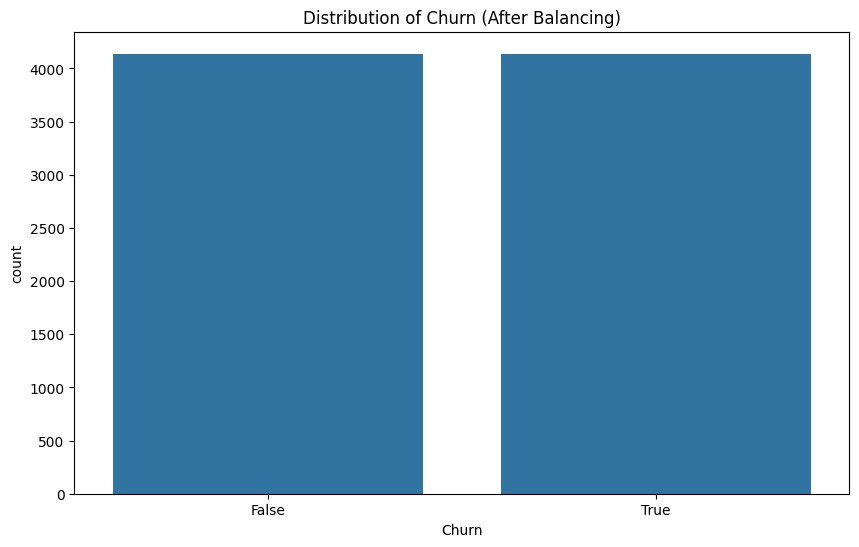

In [23]:
plt.figure(figsize=(10, 6))
sns.countplot(x=y_resampled)
plt.title('Distribution of Churn (After Balancing)')
plt.show()

In [24]:
resampled_data = pd.concat([pd.DataFrame(X_resampled), pd.Series(y_resampled, name='Churn Flag')], axis=1)

In [26]:
pip.main(['install','azureml.core.online_endpoint'])
pip.main(['install','azureml.core.online_deployment'])
from azureml.core import Workspace, Experiment, Model, Environment
from azureml.core.model import InferenceConfig
from azureml.core.webservice import AciWebservice
from azureml.core.online_endpoint import OnlineEndpoint, AzureMLOnlineEndpointPolicy
from azureml.core.online_deployment import OnlineDeployment

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


ERROR: Could not find a version that satisfies the requirement azureml.core.online_endpoint (from versions: none)


ERROR: No matching distribution found for azureml.core.online_endpoint


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


ERROR: Could not find a version that satisfies the requirement azureml.core.online_deployment (from versions: none)


ERROR: No matching distribution found for azureml.core.online_deployment


ModuleNotFoundError: No module named 'azureml.core.online_endpoint'

In [31]:
!pip install azureml.core.online_endpoint
from azureml.core import Dataset


ERROR: Could not find a version that satisfies the requirement azureml.core.online_endpoint (from versions: none)
ERROR: No matching distribution found for azureml.core.online_endpoint


In [28]:
ws = Workspace.from_config()
datastore = ws.get_default_datastore()

Found the config file in: /config.json

In [29]:
import numpy as np
from scipy.sparse import csr_matrix

# Identify columns that might contain sparse matrices
for column in resampled_data.columns:
    if isinstance(resampled_data[column].iloc[0], csr_matrix):
        resampled_data[column] = resampled_data[column].apply(lambda x: x.toarray() if isinstance(x, csr_matrix) else x)


In [34]:
for column in resampled_data.select_dtypes(include=['object']).columns:
    resampled_data[column] = resampled_data[column].astype(str)
# Register the dataset
dataset = Dataset.Tabular.register_pandas_dataframe(
    dataframe=resampled_data, 
    target=datastore, 
    name='churn_prediction_balanced'
)

Validating arguments.
Arguments validated.
Validating arguments.
Arguments validated.
'overwrite' is set to True. Any file already present in the target will be overwritten.
Uploading files from '/tmp/tmppgm1zch0' to 'managed-dataset/db343d28-0d75-4dba-b1af-f1ab7d019301/'
Copying 1 files with concurrency set to 1
Copied /tmp/tmppgm1zch0/dataframe.parquet, file 1 out of 1. Destination path: https://telecustomerch4599935195.blob.core.windows.net/azureml-blobstore-2eda2c6f-2cd5-44b8-be37-49f1633c2976/managed-dataset/db343d28-0d75-4dba-b1af-f1ab7d019301/dataframe.parquet
Successfully uploaded file to datastore.
Creating and registering a new dataset.
Files copied=1, skipped=0, failed=0
Successfully created and registered a new dataset.


In [37]:
from azureml.core import Model

from azureml.core.model import InferenceConfig


from azureml.core.webservice import AciWebservice

# Define the deployment configuration
aci_config = AciWebservice.deploy_configuration(
    cpu_cores=1,  # Number of CPU cores
    memory_gb=1,  # Amount of memory in GB
    enable_app_insights=True  # Enable Application Insights for monitoring
)


service = Model.deploy(workspace=ws,
    name="churn-prediction-service",
    models=[model],
    inference_config=inference_config,
    deployment_config=aci_config)

service.wait_for_deployment(show_output=True)

print(f"Scoring URI: {service.scoring_uri}")

ERROR: entry_script score.py doesn't exist. entry_script should be path relative to current working directory



WebserviceException: WebserviceException:
	Message: entry_script score.py doesn't exist. entry_script should be path relative to current working directory
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "entry_script score.py doesn't exist. entry_script should be path relative to current working directory"
    }
}

In [38]:
X

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,No phone service,DSL,No,...,No,No,No,No,Month-to-month,True,Electronic check,29.85,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,No,DSL,Yes,...,Yes,No,No,No,One year,False,Mailed check,56.95,1889.50,False
2,3668-QPYBK,Male,0,False,False,2,True,No,DSL,Yes,...,No,No,No,No,Month-to-month,True,Mailed check,53.85,108.15,True
3,7795-CFOCW,Male,0,False,False,45,False,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,False,Bank transfer (automatic),42.30,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,No,Fiber optic,No,...,No,No,No,No,Month-to-month,True,Electronic check,70.70,151.65,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,True,True,24,True,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,True,Mailed check,84.80,1990.50,False
7039,2234-XADUH,Female,0,True,True,72,True,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,True,Credit card (automatic),103.20,7362.90,False
7040,4801-JZAZL,Female,0,True,True,11,False,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,True,Electronic check,29.60,346.45,False
7041,8361-LTMKD,Male,1,True,False,4,True,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,True,Mailed check,74.40,306.60,True


In [40]:
y

0       False
1       False
2        True
3       False
4        True
        ...  
7038    False
7039    False
7040    False
7041     True
7042    False
Name: Churn, Length: 7043, dtype: bool